### load library

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,sys, gc, keras

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC,generate_representation

folder = "../../KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"
#folder_lc = "/media/fmena/KOI_LC/"

Using TensorFlow backend.


In [2]:
df_sets = pd.read_csv(folder+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [3]:
df_meta = pd.read_csv(folder+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

### load data

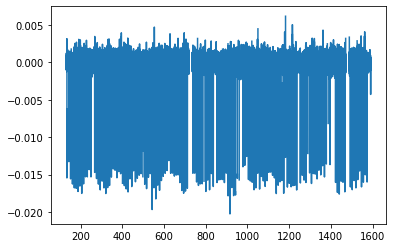

(8054, 71427)


In [4]:
time_kepler = np.load(folder_lc+"npy/KOI_LC_time.npy")
process_lc = np.load(folder_lc+'/cleaned/LC_kepler_processed.npy')
N, T = time_kepler.shape

plt.plot(time_kepler[0],process_lc[0])
plt.show()
print((N,T))

In [5]:
#borrar nans... arreglo variable
coupled_lc = []
delta_time = []
lens_lc = []
for i in range(N):
    mask_nan = np.isnan(process_lc[i])
    coupled_lc.append(process_lc[i][~mask_nan])
    
    time = time_kepler[i][~mask_nan]
    # calculate delta time --> this could be done after padding is done..
    delta_time.append(np.hstack([[0],np.diff(time)]))
    lens_lc.append(np.sum(~mask_nan))
    
coupled_lc = np.asarray(coupled_lc)
delta_time = np.asarray(delta_time)
delta_time

array([array([0.       , 0.0204347, 0.0204346, ..., 0.0204347, 0.0204346,
       0.0204347]),
       array([0.       , 0.0408658, 0.0204329, ..., 0.0204347, 0.0204345,
       0.0204348]),
       array([0.       , 0.0204347, 0.0204345, ..., 0.0204346, 0.0204346,
       0.0204347]),
       ...,
       array([0.       , 0.0204343, 0.0204342, ..., 0.0204342, 0.020434 ,
       0.0204343]),
       array([0.       , 0.0204343, 0.0204342, ..., 0.0204342, 0.020434 ,
       0.0204343]),
       array([0.       , 0.0204342, 0.0204342, ..., 0.0204341, 0.0204341,
       0.0204343])], dtype=object)

In [6]:
for i in range(coupled_lc.shape[0]):
    #std_i = coupled_lc[i].std(keepdims=True)
    min_i = coupled_lc[i].min(keepdims=True)
    coupled_lc[i] = coupled_lc[i]/min_i  
coupled_lc.shape

(8054,)

In [7]:
## data augmentation -- como el paper que nos cito...
#flip/mirror cada curva de luz.. (así se duplican los datos..) time: tambn y shift del 0 que sobra..

flip_coupled_lc = []
flip_delta_time = []
for i in range(coupled_lc.shape[0]):    
    flip_coupled_lc.append( coupled_lc[i][::-1] )
    flip_delta_time.append(  np.hstack([[0], delta_time[i][1:][::-1]]) )
    
flip_coupled_lc = np.asarray(flip_coupled_lc)
flip_delta_time = np.asarray(flip_delta_time)

delta_time = np.concatenate([delta_time, flip_delta_time])
coupled_lc = np.concatenate([coupled_lc, flip_coupled_lc])

del flip_delta_time, flip_coupled_lc
gc.collect()
coupled_lc.shape

(16108,)

### Build representation

In [8]:
max_len = np.max(lens_lc)

## do padding with keras..
X_time = keras.preprocessing.sequence.pad_sequences(delta_time,maxlen=max_len, value=0,dtype='float32',padding='post')
X_lc = keras.preprocessing.sequence.pad_sequences(coupled_lc,maxlen=max_len, value=0,dtype='float32',padding='post')

print("Shape with padding: ", X_lc.shape)
X_lc

Shape with padding:  (16108, 64482)


array([[ 0.01648676,  0.04718132,  0.01580917, ...,  0.        ,
         0.        ,  0.        ],
       [-0.2970667 ,  0.03325527, -0.06651054, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.85585386,  0.73092735, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.25538528, -0.16241421, -0.03414796, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.25065646, -0.16456528, -0.03672105, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06703797,  0.20654422, -0.06743483, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [9]:
#add extra dim
X_lc = np.expand_dims(np.squeeze(X_lc),axis=-1)
X_time = np.expand_dims(np.squeeze(X_time),axis=-1)

N_aug, T, _ = X_lc.shape
channels = 2
print("new - Shape: ", X_lc.shape)

new - Shape:  (16108, 64482, 1)


In [10]:
#set train mask
X_lc_train = np.concatenate([X_lc[:N][mask_train], X_lc[N:][mask_train]], axis=0) 
X_time_train = np.concatenate([X_time[:N][mask_train], X_time[N:][mask_train]], axis=0) 

if X_lc_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))
    
X_lc_val = X_lc[:N][mask_test]
X_time_val =  X_time[:N][mask_test]

print("X train shape ",X_lc_train.shape)
print("X val shape ",X_lc_val.shape)

print("y train shape ",y_train.shape)
print("y val shape ",y_val.shape)

X train shape  (8678, 64482, 1)
X val shape  (1918, 64482, 1)
y train shape  (8678,)
y val shape  (1918,)


### Define Model

In [11]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, Dense, Flatten, MaxPool1D, Reshape, UpSampling1D, Lambda, AveragePooling1D
from keras.layers import GlobalAveragePooling1D,GlobalMaxPool1D, TimeDistributed, GRU,LSTM, RepeatVector, SimpleRNN
from keras.layers import BatchNormalization, Dropout, ZeroPadding1D, ZeroPadding2D, Cropping1D, Cropping2D, Conv2D, Conv2DTranspose, MaxPool2D,UpSampling2D

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [12]:
def add_CNN(it, filters, kernel_s, act='relu', dil_r=1, BN = False, **args):
    f1 = Conv1D(filters, kernel_s, activation=act, dilation_rate=dil_r, **args)(it)
    if BN:
        f1 = BatchNormalization()(f1)
    return f1
                                                           
def conv_bloq(it, filters, kernel_s, pool, drop=0, dil_r=1, act='relu', BN=False,double=False, **args):
    ## **args could be any other conv1d parameter
    f1 = add_CNN(it, filters, kernel_s, act=act, dil_r=dil_r, BN = BN, **args)
    if double:
        f1 = add_CNN(f1, filters, kernel_s, act=act, dil_r=dil_r, BN = BN, **args)
        
    if pool!= 0 and dil_r ==1:
        #f1 = MaxPool1D(pool_size=pool, strides=pool, padding='valid')(f1)
        f1 = AveragePooling1D(pool_size=pool, strides=pool, padding='valid')(f1)
    if drop != 0:
        f1 = Dropout(drop)(f1)
    return f1

def encoder_model_CNN1D(input_dim, channels, L=1, filters=8, kernel_s =10, pool=5, BN=False, drop=0,
                        dil_r=1, flatten =True,time=False,double=False, **args): 
    #parametros estructurales-- args es cuqluier parameter de conv1d
    it = Input(shape=(input_dim,channels))  #fixed length..
    f1 = it
    start_f = filters
    for l in range(L):
        f1 = conv_bloq(f1, filters, kernel_s, pool, drop=drop,dil_r=dil_r,BN=BN,double=double, **args) 
        
        filters = int(filters*2)
        filters = min(128, filters)
        if time:
            filters = min(64, filters)
        if dil_r != 1:
            dil_r = int(dil_r*2)
            
    if flatten:
        f1 = Flatten()(f1)
    else:
        #f1 = GlobalMaxPool1D()(f1)
        f1 = GlobalAveragePooling1D()(f1)
    return Model(inputs=it, outputs=f1)

In [13]:
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from evaluation import calculate_metrics, plot_ROC

def evaluate_model(model, data, y):
    predichos_prob = model.predict(data)

    predichos = predichos_prob >= 0.5

    calculate_metrics(y, predichos,'[VAL] Confusion Matrix')
    plot_ROC(y, predichos_prob)

In [14]:
EPOCHS = 50
BATCH_s = 128

In [15]:
## original: C aguirre 
encoder  = encoder_model_CNN1D(T, 1, L=2, filters=32, pool=2, kernel_s=40, drop=0.0) 
encoder_t = encoder # pero la curva son deltas tambn...

encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64482, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64443, 32)         1312      
_________________________________________________________________
average_pooling1d_1 (Average (None, 32221, 32)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32182, 64)         81984     
_________________________________________________________________
average_pooling1d_2 (Average (None, 16091, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1029824)           0         
Total params: 83,296
Trainable params: 83,296
Non-trainable params: 0


In [15]:
## inspirado en Shallue: 
encoder  = encoder_model_CNN1D(T, 1, L=5, filters=16, pool=2, kernel_s=5, drop=0.0) 
encoder_t  = encoder_model_CNN1D(T, 1, L=5, filters=16, pool=2, kernel_s=5, drop=0.0, time=True) 

encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64482, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64478, 16)         96        
_________________________________________________________________
average_pooling1d_1 (Average (None, 32239, 16)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32235, 32)         2592      
_________________________________________________________________
average_pooling1d_2 (Average (None, 16117, 32)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16113, 64)         10304     
_________________________________________________________________
aver

In [15]:
#aumenta pool (mas rapido)
encoder   = encoder_model_CNN1D(T, 1, L=5, filters=16, pool=3, kernel_s=5, drop=0.0) 
encoder_t = encoder_model_CNN1D(T, 1, L=5, filters=16, pool=3, kernel_s=5, drop=0.0, time=True) #model

encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64482, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64478, 16)         96        
_________________________________________________________________
average_pooling1d_1 (Average (None, 21492, 16)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21488, 32)         2592      
_________________________________________________________________
average_pooling1d_2 (Average (None, 7162, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7158, 64)          10304     
_________________________________________________________________
aver

In [15]:
#Kernel 8 y pool 3
encoder   = encoder_model_CNN1D(T, 1, L=5, filters=16, pool=3, kernel_s=8, drop=0.0) 
encoder_t = encoder_model_CNN1D(T, 1, L=5, filters=16, pool=3, kernel_s=8, drop=0.0, time=True) #model

encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64482, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64475, 16)         144       
_________________________________________________________________
average_pooling1d_1 (Average (None, 21491, 16)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21484, 32)         4128      
_________________________________________________________________
average_pooling1d_2 (Average (None, 7161, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7154, 64)          16448     
_________________________________________________________________
aver

In [16]:
## combine two "tower"
it_time = Input(shape=X_time.shape[1:])
it_lc = Input(shape=X_lc.shape[1:])
encoder_time = encoder_t(it_time)
encoder_lc = encoder(it_lc)
concat_encoder = keras.layers.Concatenate()([encoder_time,encoder_lc])

f1 = Dropout(0.5)(concat_encoder)

#similar FF layer of baseline
f1 = Dense(128, activation='relu')(f1)
f1 = Dropout(0.5)(f1)
out = Dense(1, activation='sigmoid')(f1)

CNN_all = Model([it_time,it_lc], out)
CNN_all.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
CNN_all.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64482, 1)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 64482, 1)     0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16704)        86384       input_3[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 33408)        217584      input_4[0][0]               

In [17]:
CNN_all.fit([X_time_train, X_lc_train], y_train, epochs=EPOCHS, batch_size=BATCH_s, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
8678/8678 [==============================] - 2916s 336ms/step - loss: 0.7114 - acc: 0.6813
Epoch 2/20
8678/8678 [==============================] - 2649s 305ms/step - loss: 0.5080 - acc: 0.7247
Epoch 3/20
8678/8678 [==============================] - 2537s 292ms/step - loss: 0.4743 - acc: 0.7413
Epoch 4/20
8678/8678 [==============================] - 2550s 294ms/step - loss: 0.4388 - acc: 0.7562
Epoch 5/20
8678/8678 [==============================] - 2580s 297ms/step - loss: 0.4006 - acc: 0.7817
Epoch 6/20
8678/8678 [==============================] - 2598s 299ms/step - loss: 0.3711 - acc: 0.8011
Epoch 7/20
8678/8678 [==============================] - 2620s 302ms/step - loss: 0.3357 - acc: 0.8248
Epoch 8/20
8678/8678 [==============================] - 2865s 330ms/step - loss: 0.2825 - acc: 0.8605
Epoch 9/20
8678/8678 [==============================] - 3164s 365ms/step - loss: 0.2433 - acc: 0.8920
Epoch 10/20
8678/8678 [===========

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.744056,0.853248,0.794920,0.70095,0.660618,0.713764
Confirmed,0.625000,0.454545,0.526316,0.70095,0.660618,0.713764


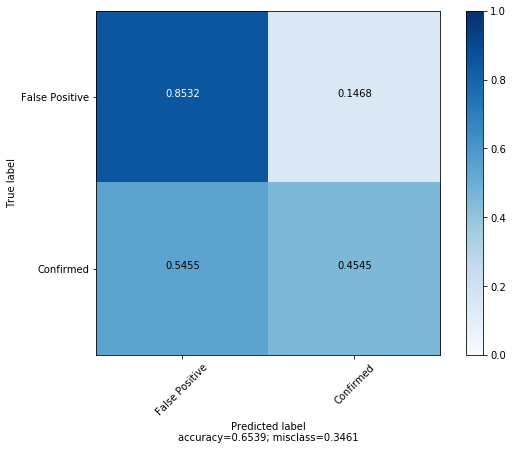

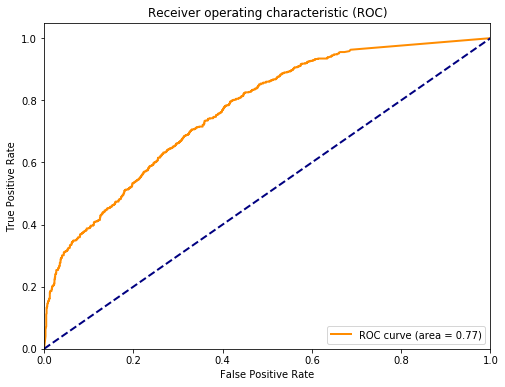

In [18]:
### C aguirre original
evaluate_model(CNN_all, [X_time_val, X_lc_val], y_val)

In [17]:
CNN_all.fit([X_time_train, X_lc_train], y_train, epochs=EPOCHS, batch_size=BATCH_s, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
8678/8678 [==============================] - 983s 113ms/step - loss: 0.5696 - acc: 0.6795
Epoch 2/30
8678/8678 [==============================] - 950s 110ms/step - loss: 0.5207 - acc: 0.7135
Epoch 3/30
8678/8678 [==============================] - 955s 110ms/step - loss: 0.5032 - acc: 0.7263
Epoch 4/30
8678/8678 [==============================] - 952s 110ms/step - loss: 0.4944 - acc: 0.7376
Epoch 5/30
8678/8678 [==============================] - 779s 90ms/step - loss: 0.4689 - acc: 0.7502
Epoch 6/30
8678/8678 [==============================] - 777s 90ms/step - loss: 0.4475 - acc: 0.7691
Epoch 7/30
8678/8678 [==============================] - 774s 89ms/step - loss: 0.4385 - acc: 0.7703
Epoch 8/30
8678/8678 [==============================] - 775s 89ms/step - loss: 0.4176 - acc: 0.7855
Epoch 9/30
8678/8678 [==============================] - 776s 89ms/step - loss: 0.3762 - acc: 0.8118
Epoch 10/30
8678/8678 [=========================

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.780415,0.843625,0.810790,0.738569,0.707571,0.744004
Confirmed,0.657895,0.558867,0.604351,0.738569,0.707571,0.744004


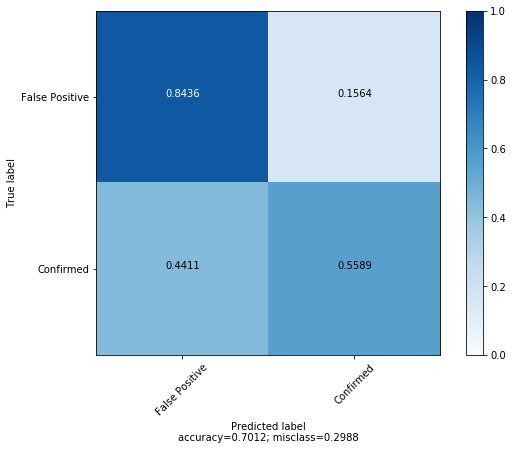

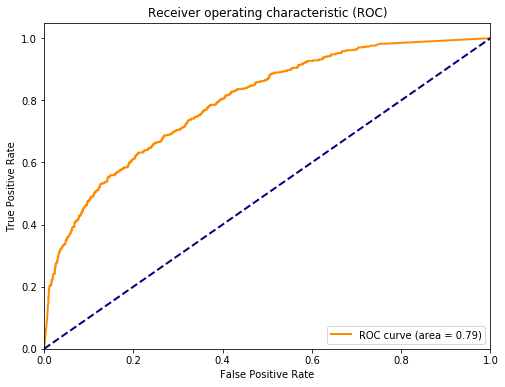

In [18]:
### Shallue inspired
evaluate_model(CNN_all, [X_time_val, X_lc_val], y_val)

In [19]:
CNN_all.fit([X_time_train, X_lc_train], y_train, epochs=10, batch_size=BATCH_s, verbose=1)

Epoch 1/10
8678/8678 [==============================] - 781s 90ms/step - loss: 0.0650 - acc: 0.9771
Epoch 2/10
8678/8678 [==============================] - 783s 90ms/step - loss: 0.0573 - acc: 0.9783
Epoch 3/10
8678/8678 [==============================] - 786s 91ms/step - loss: 0.0609 - acc: 0.9797
Epoch 4/10
8678/8678 [==============================] - 781s 90ms/step - loss: 0.0744 - acc: 0.9740
Epoch 5/10
8678/8678 [==============================] - 785s 90ms/step - loss: 0.0576 - acc: 0.9806
Epoch 6/10
8678/8678 [==============================] - 778s 90ms/step - loss: 0.0538 - acc: 0.9824
Epoch 7/10
8678/8678 [==============================] - 777s 89ms/step - loss: 0.0642 - acc: 0.9774
Epoch 8/10
8678/8678 [==============================] - 777s 90ms/step - loss: 0.0531 - acc: 0.9805
Epoch 9/10
8678/8678 [==============================] - 785s 90ms/step - loss: 0.0498 - acc: 0.9839
Epoch 10/10
8678/8678 [==============================] - 787s 91ms/step - loss: 0.0485 - acc: 0.9846

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.800163,0.786688,0.793368,0.734498,0.70923,0.733577
Confirmed,0.615607,0.634873,0.625092,0.734498,0.70923,0.733577


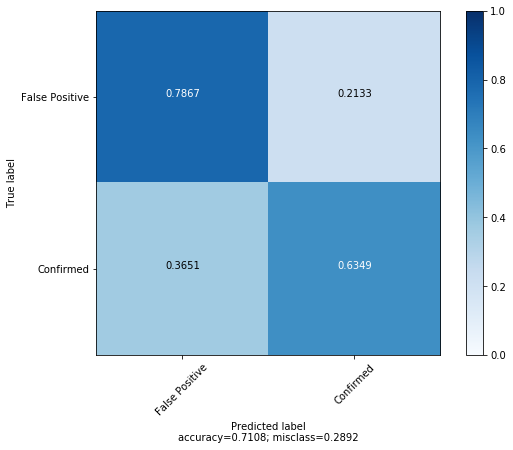

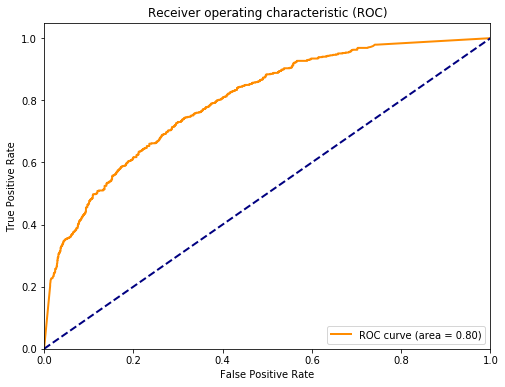

In [20]:
### Shallue inspired
evaluate_model(CNN_all, [X_time_val, X_lc_val], y_val)

In [17]:
CNN_all.fit([X_time_train, X_lc_train], y_train, epochs=EPOCHS, batch_size=BATCH_s, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
8678/8678 [==============================] - 342s 39ms/step - loss: 0.5797 - acc: 0.6636
Epoch 2/50
8678/8678 [==============================] - 348s 40ms/step - loss: 0.5330 - acc: 0.7110
Epoch 3/50
8678/8678 [==============================] - 355s 41ms/step - loss: 0.5137 - acc: 0.7212
Epoch 4/50
8678/8678 [==============================] - 360s 42ms/step - loss: 0.5028 - acc: 0.7277
Epoch 5/50
8678/8678 [==============================] - 366s 42ms/step - loss: 0.5023 - acc: 0.7293
Epoch 6/50
8678/8678 [==============================] - 371s 43ms/step - loss: 0.4915 - acc: 0.7282
Epoch 7/50
8678/8678 [==============================] - 370s 43ms/step - loss: 0.4867 - acc: 0.7290
Epoch 8/50
8678/8678 [==============================] - 373s 43ms/step - loss: 0.4821 - acc: 0.7338
Epoch 9/50
8678/8678 [==============================] - 370s 43ms/step - loss: 0.4786 - acc: 0.7336
Epoch 10/50
8678/8678 [=============================

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.808743,0.830794,0.819620,0.760761,0.735498,0.762252
Confirmed,0.668760,0.634873,0.651376,0.760761,0.735498,0.762252


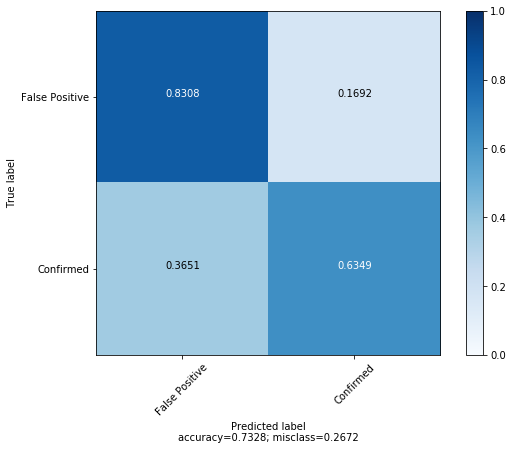

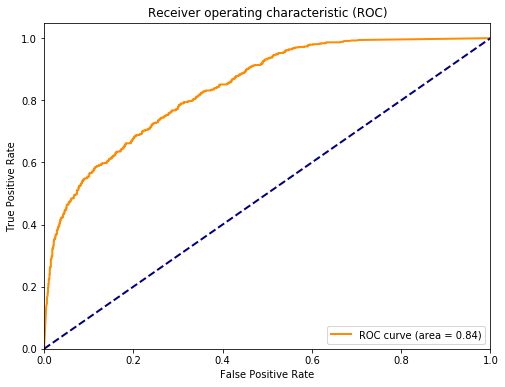

In [18]:
### Shallue inspired poolx3
evaluate_model(CNN_all, [X_time_val, X_lc_val], y_val)

In [21]:
CNN_all.fit([X_time_train, X_lc_train], y_train, epochs=EPOCHS, batch_size=BATCH_s, verbose=1)

Epoch 1/50
8678/8678 [==============================] - 497s 57ms/step - loss: 0.5774 - acc: 0.6835
Epoch 2/50
8678/8678 [==============================] - 489s 56ms/step - loss: 0.5289 - acc: 0.7139
Epoch 3/50
8678/8678 [==============================] - 494s 57ms/step - loss: 0.5196 - acc: 0.7183
Epoch 4/50
8678/8678 [==============================] - 498s 57ms/step - loss: 0.4972 - acc: 0.7276
Epoch 5/50
8678/8678 [==============================] - 503s 58ms/step - loss: 0.4990 - acc: 0.7290
Epoch 6/50
8678/8678 [==============================] - 494s 57ms/step - loss: 0.4884 - acc: 0.7279
Epoch 7/50
8678/8678 [==============================] - 497s 57ms/step - loss: 0.4866 - acc: 0.7310
Epoch 8/50
8678/8678 [==============================] - 496s 57ms/step - loss: 0.4801 - acc: 0.7373
Epoch 9/50
8678/8678 [==============================] - 496s 57ms/step - loss: 0.4774 - acc: 0.7448
Epoch 10/50
8678/8678 [==============================] - 494s 57ms/step - loss: 0.4692 - acc: 0.7557

KeyboardInterrupt: 

In [20]:
%%time
CNN_all.predict([X_time_val, X_lc_val])

CPU times: user 4min 13s, sys: 34.4 s, total: 4min 47s
Wall time: 25.5 s


array([[0.0528973 ],
       [0.01655242],
       [0.39927474],
       ...,
       [0.17521283],
       [0.416083  ],
       [0.42467016]], dtype=float32)

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.814456,0.876504,0.844341,0.785737,0.760583,0.789885
Confirmed,0.732639,0.628912,0.676824,0.785737,0.760583,0.789885


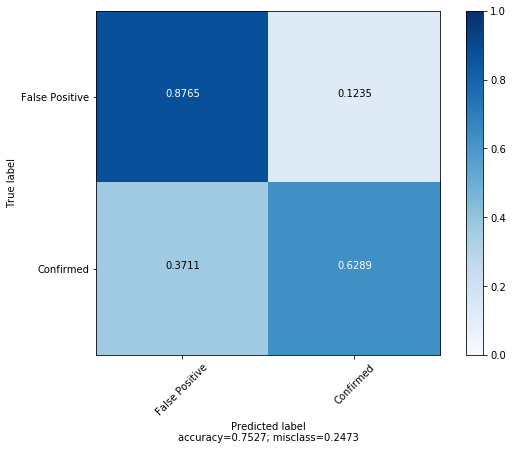

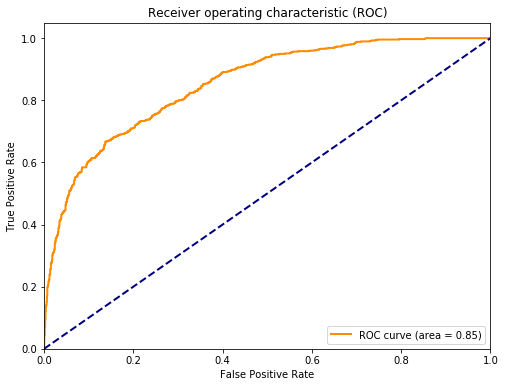

In [22]:
### Shallue inspired poolx3-bigger kernel
evaluate_model(CNN_all, [X_time_val, X_lc_val], y_val) #hasta 30

In [23]:
CNN_all.fit([X_time_train, X_lc_train], y_train, epochs=20, batch_size=BATCH_s, verbose=1)

Epoch 1/20
8678/8678 [==============================] - 494s 57ms/step - loss: 0.2371 - acc: 0.8940
Epoch 2/20
8678/8678 [==============================] - 492s 57ms/step - loss: 0.2305 - acc: 0.8987
Epoch 3/20
8678/8678 [==============================] - 494s 57ms/step - loss: 0.2209 - acc: 0.9044
Epoch 4/20
8678/8678 [==============================] - 499s 58ms/step - loss: 0.2045 - acc: 0.9083
Epoch 5/20
8678/8678 [==============================] - 492s 57ms/step - loss: 0.1945 - acc: 0.9146
Epoch 6/20
8678/8678 [==============================] - 493s 57ms/step - loss: 0.1798 - acc: 0.9203
Epoch 7/20
8678/8678 [==============================] - 494s 57ms/step - loss: 0.1709 - acc: 0.9298
Epoch 8/20
8678/8678 [==============================] - 495s 57ms/step - loss: 0.1666 - acc: 0.9311
Epoch 9/20
8678/8678 [==============================] - 490s 57ms/step - loss: 0.1730 - acc: 0.9295
Epoch 10/20
8678/8678 [==============================] - 493s 57ms/step - loss: 0.1601 - acc: 0.9358

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.831461,0.830794,0.831127,0.780538,0.758825,0.780501
Confirmed,0.686012,0.687034,0.686523,0.780538,0.758825,0.780501


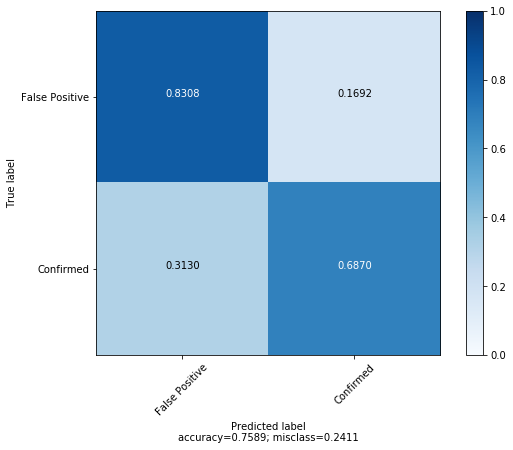

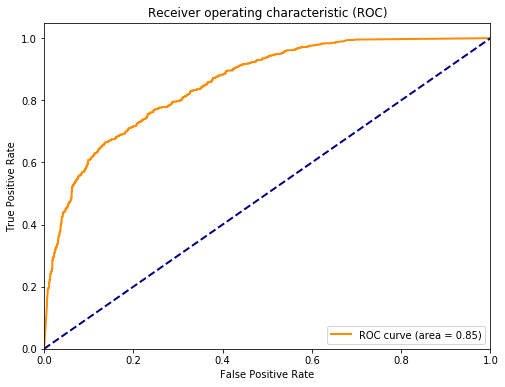

In [24]:
### Shallue inspired poolx3-bigger kernel
evaluate_model(CNN_all, [X_time_val, X_lc_val], y_val) #hasta 50

### CNN casual+dilation 
> WaveNet

In [ ]:
encoder  = encoder_model_CNN1D(T, 1, L=.., filters=.., kernel_s=.., drop=0.0, flatten=False,dil_r=2, padding='causal' ) 
